In [1]:
import os
import pandas as pd
# List all files in the directory
df_folder = '/data/home/natant/Negatives/Runs/full_run_3/cross_TF_perf'
df_files = [f for f in os.listdir(df_folder) if f.endswith('.csv')]

# Load each CSV as a DataFrame and store in a dictionary, using the first column as index
cross_TF_dfs = {}
for fname in df_files:
    key = fname.replace('.csv', '')
    cross_TF_dfs[key] = pd.read_csv(os.path.join(df_folder, fname), index_col=0)

# Show loaded keys
print("Loaded DataFrames:", list(cross_TF_dfs.keys()))

Loaded DataFrames: ['A549_dinucl_sampled_CV-5_AUROC_HQ', 'A549_shuffled_CV-4_AUROC_HQ', 'A549_shuffled_CV-0_AUROC_HQ', 'A549_dinucl_sampled_CV-4_AUROC', 'A549_dinucl_sampled_CV-1_AUROC_HQ', 'A549_dinucl_shuffled_CV-5_AUROC_HQ', 'A549_dinucl_shuffled_CV-4_AUROC', 'A549_dinucl_shuffled_CV-1_AUROC', 'A549_dinucl_shuffled_CV-5_AUROC', 'A549_dinucl_shuffled_CV-3_AUROC_HQ', 'A549_shuffled_CV-5_AUROC_HQ', 'A549_dinucl_sampled_CV-2_AUROC', 'A549_dinucl_shuffled_CV-2_AUROC', 'A549_shuffled_CV-2_AUROC_HQ', 'A549_dinucl_shuffled_CV-0_AUROC_HQ', 'A549_shuffled_CV-2_AUROC', 'A549_dinucl_shuffled_CV-4_AUROC_HQ', 'A549_dinucl_sampled_CV-3_AUROC_HQ', 'A549_dinucl_sampled_CV-5_AUROC', 'A549_dinucl_shuffled_CV-0_AUROC', 'A549_dinucl_sampled_CV-0_AUROC_HQ', 'A549_shuffled_CV-3_AUROC_HQ', 'A549_shuffled_CV-1_AUROC_HQ', 'A549_dinucl_shuffled_CV-2_AUROC_HQ', 'A549_dinucl_shuffled_CV-3_AUROC', 'A549_dinucl_sampled_CV-3_AUROC', 'A549_dinucl_sampled_CV-0_AUROC', 'A549_shuffled_CV-3_AUROC', 'A549_shuffled_CV-1_

In [ ]:
import numpy as np

# Define the different types of negative samples used in the analysis
negative_types = ["dinucl_sampled", "shuffled", "dinucl_shuffled"]
# Define the metrics to analyze
metrics = ["AUROC", "AUROC_HQ"]
# Dictionary to store averaged dataframes across folds
averaged_dfs = {}

# Iterate through each negative type and metric combination
for neg in negative_types:
    for metric in metrics:
        # List to store dataframes from different CV folds
        dfs = []
        # Collect data from 6 cross-validation folds (0-5)
        for fold in range(6):
            # Construct the key to access the appropriate dataframe
            key = f"A549_{neg}_CV-{fold}_{metric}"
            # Check if the key exists in the loaded dataframes
            if key in cross_TF_dfs:
                dfs.append(cross_TF_dfs[key])
        
        # If we found any dataframes for this combination
        if len(dfs) > 0:
            # Create a union of all indices and columns to ensure all dataframes have same dimensions
            all_idx = sorted(set().union(*[df.index for df in dfs]))
            all_cols = sorted(set().union(*[df.columns for df in dfs]))
            
            # Align all dataframes to have the same rows and columns
            aligned = [df.reindex(index=all_idx, columns=all_cols) for df in dfs]
            
            # Stack the aligned dataframes to compute the mean
            stacked = np.stack([df.values for df in aligned])
            
            # Calculate the mean across folds, ignoring NaN values
            avg_matrix = np.nanmean(stacked, axis=0)
            
            # Create a new dataframe with the averaged values
            avg_df = pd.DataFrame(avg_matrix, index=all_idx, columns=all_cols)
            
            # Store the averaged dataframe with a descriptive key
            averaged_dfs[f"{neg}_{metric}"] = avg_df
        else:
            # Warning if no data was found for a particular combination
            print(f"Warning: No folds found for {neg} {metric}")

# Return the dictionary of averaged dataframes
averaged_dfs


{'dinucl_sampled_AUROC':                        ATF3   BHLHE40  CREB1_(SC-240)      CTCF  \
 ATF3               0.747499  0.662486        0.707156  0.600435   
 BHLHE40            0.779842  0.858799        0.796403  0.652025   
 CREB1_(SC-240)     0.813075  0.783464        0.873730  0.762399   
 CTCF               0.641798  0.585445        0.723776  0.970570   
 ELF1_(SC-631)      0.765135  0.725998        0.788811  0.681441   
 ETS1               0.782525  0.733945        0.796754  0.658163   
 FOSL2              0.789668  0.656765        0.681002  0.537063   
 FOXA1_(SC-101058)  0.643413  0.593188        0.643142  0.546216   
 Max                0.798877  0.826758        0.843782  0.728906   
 SIX5               0.766004  0.730325        0.773533  0.636137   
 TCF12              0.718337  0.641220        0.690618  0.594024   
 USF-1              0.714752  0.702946        0.709205  0.615178   
 YY1_(SC-281)       0.755310  0.701221        0.808960  0.728128   
 ZBTB33             0.76

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_side_by_side_heatmaps(df1, df2, title1=None, title2=None, figsize=(18, 8), 
                              use_global_scale=True, vmin=None, vmax=None):
    """
    Create two side-by-side heatmaps for comparing dataframes.
    
    Parameters:
    df1, df2: pandas DataFrames to plot
    title1, title2: titles for each heatmap (optional)
    figsize: figure size tuple
    use_global_scale: if True, use same color scale for both heatmaps
    vmin, vmax: custom min/max values for color scale (overrides use_global_scale)
    """
    # Determine TF order based on first dataframe's diagonal mean
    TF_order = df1.mean(axis=1).sort_values(ascending=False).index.to_list()
    
    # Reorder both dataframes
    df1_ordered = df1.loc[TF_order, TF_order]
    df2_ordered = df2.loc[TF_order, TF_order]
    
    # Set color scale
    if vmin is None or vmax is None:
        if use_global_scale:
            vmin = min(df1_ordered.min().min(), df2_ordered.min().min())
            vmax = max(df1_ordered.max().max(), df2_ordered.max().max())
        else:
            vmin, vmax = None, None
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Create short labels
    short_labels_ordered = [label.split("_")[0] for label in TF_order]
    
    # Plot first heatmap
    sns.heatmap(df1_ordered, annot=True, cmap="RdYlBu", fmt=".2f",
                xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, 
                ax=axes[0], vmin=vmin, vmax=vmax)
    axes[0].xaxis.set_ticks_position('top')
    axes[0].xaxis.set_label_position('top')
    if title1:
        axes[0].set_title(title1, pad=40)
    axes[0].set_ylabel("TF the model was trained on")
    axes[0].set_xlabel("Tested TF")
    axes[0].tick_params(axis='x', rotation=45, labelrotation=45)
    
    # Plot second heatmap
    sns.heatmap(df2_ordered, annot=True, cmap="RdYlBu", fmt=".2f",
                xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, 
                ax=axes[1], vmin=vmin, vmax=vmax)
    axes[1].xaxis.set_ticks_position('top')
    axes[1].xaxis.set_label_position('top')
    if title2:
        axes[1].set_title(title2, pad=40)
    axes[1].set_ylabel("TF the model was trained on")
    axes[1].set_xlabel("Tested TF")
    axes[1].tick_params(axis='x', rotation=45, labelrotation=45)
    
    plt.tight_layout()
    plt.show()


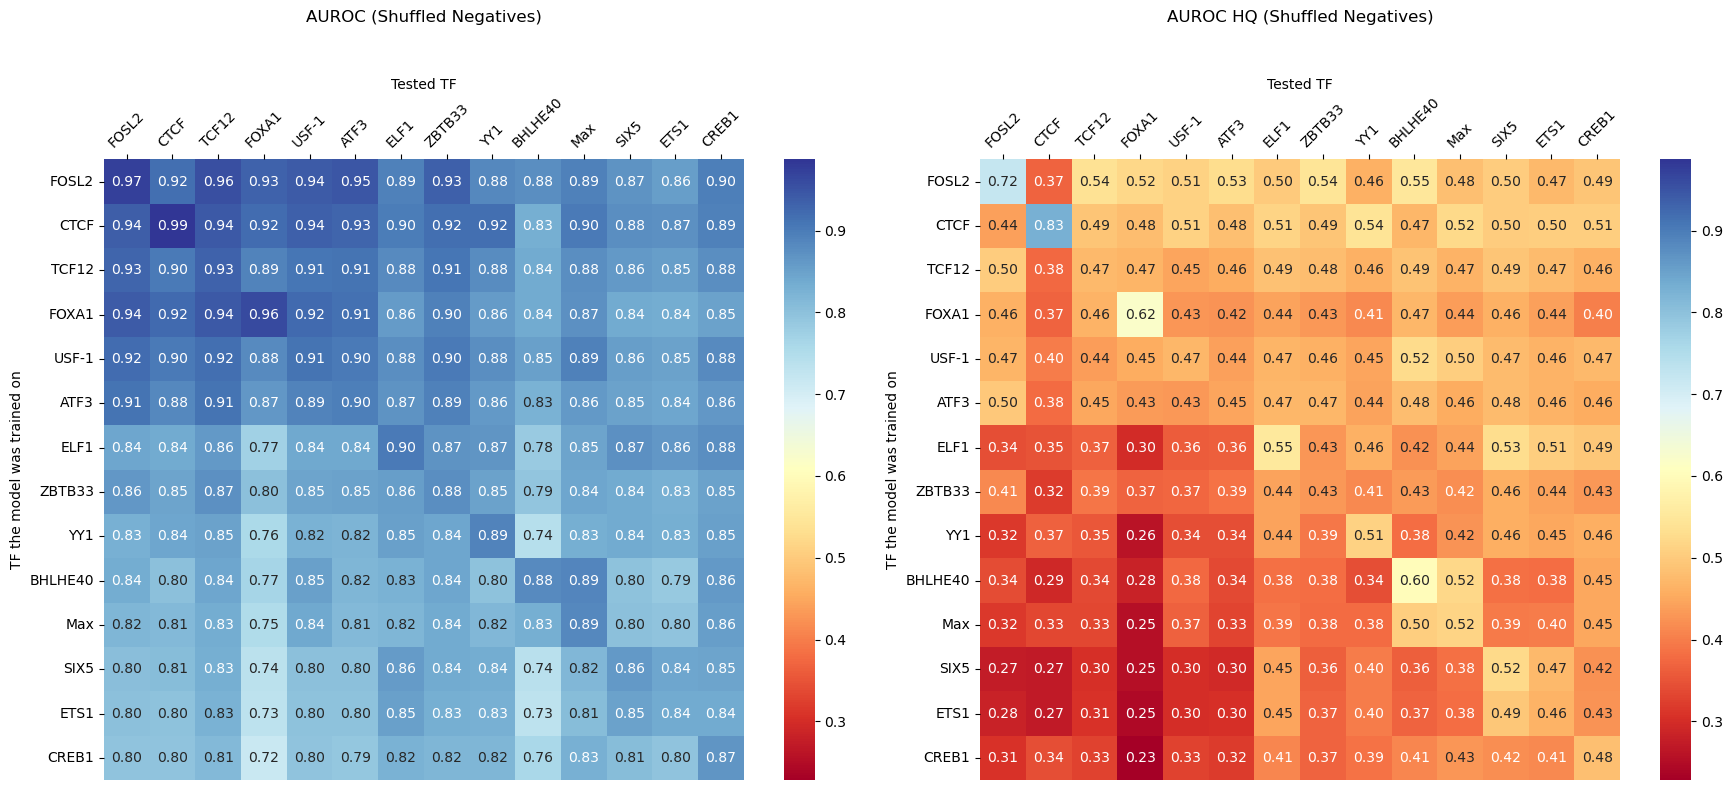

In [ ]:
# Example usage for comparing metrics within same neg_mode:
plot_side_by_side_heatmaps(
    averaged_dfs["shuffled_AUROC"], 
    averaged_dfs["shuffled_AUROC_HQ"],
    "AUROC (Shuffled Negatives)", 
    "AUROC HQ (Shuffled Negatives)"
)


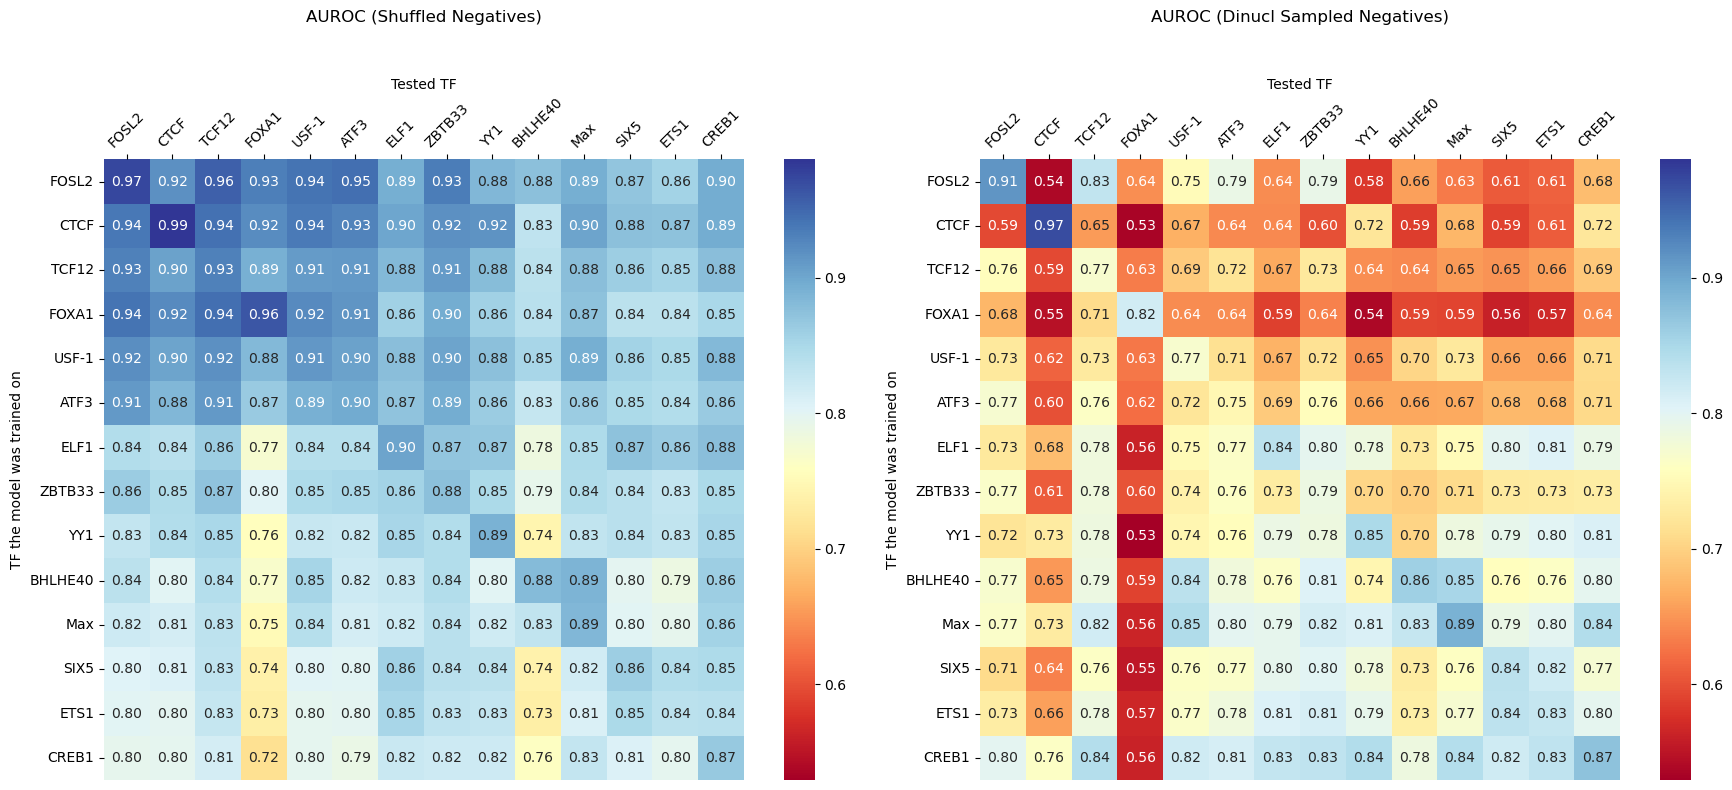

In [19]:
# Example usage for comparing same metric between neg_modes:
plot_side_by_side_heatmaps(
    averaged_dfs["shuffled_AUROC"], 
    averaged_dfs["dinucl_sampled_AUROC"],
    "AUROC (Shuffled Negatives)", 
    "AUROC (Dinucl Sampled Negatives)"
)

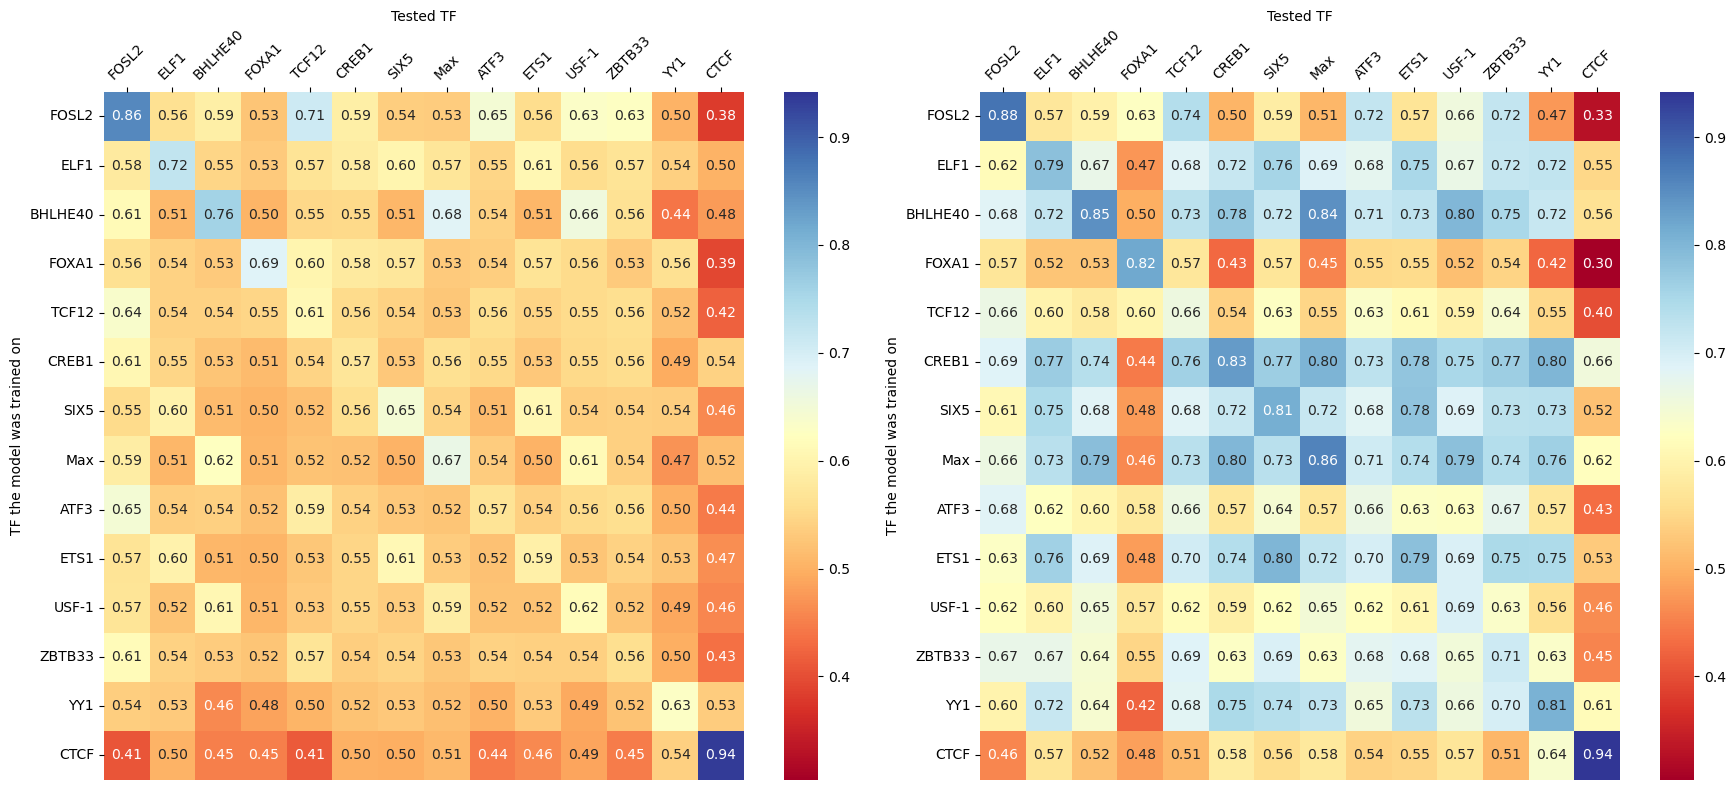

In [22]:
# Example usage for comparing same metric between neg_modes:
plot_side_by_side_heatmaps(
    averaged_dfs["dinucl_shuffled_AUROC_HQ"], 
    averaged_dfs["dinucl_sampled_AUROC_HQ"]
)

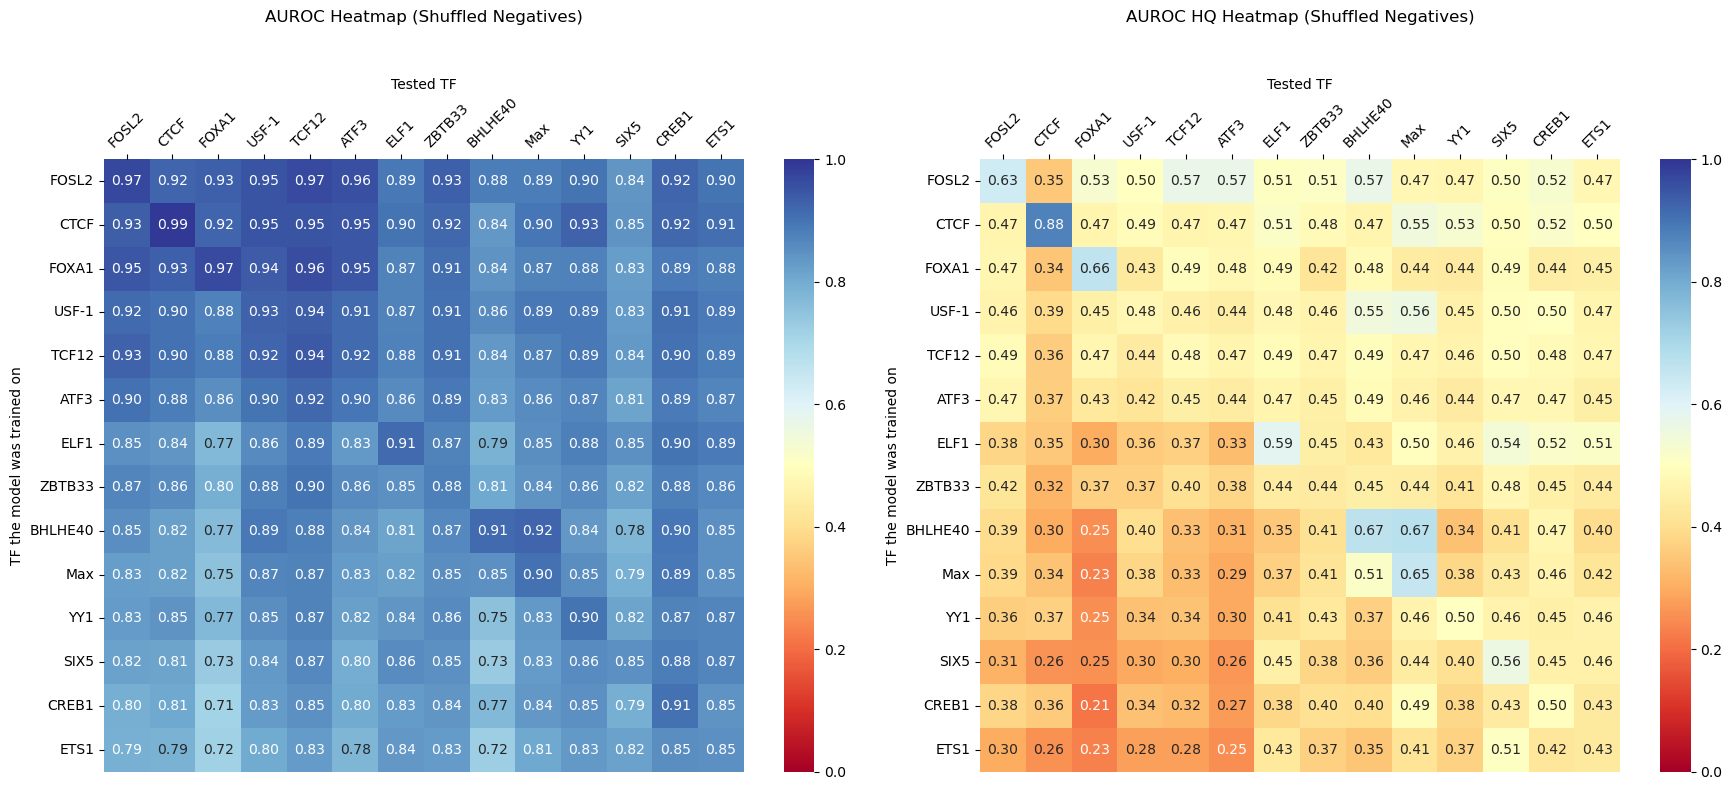

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

AUROC_df = cross_TF_dfs["A549_shuffled_CV-0_AUROC"]
TF_order = AUROC_df.mean(axis=1).sort_values(ascending=False).index.to_list()
AUROC_df = AUROC_df.loc[TF_order, TF_order]
AUROC_HQ_df = cross_TF_dfs["A549_shuffled_CV-0_AUROC_HQ"]
AUROC_HQ_df = AUROC_HQ_df.loc[TF_order, TF_order]
# Find global min and max for both heatmaps
# vmin = min(AUROC_HQ_df.min().min(), AUROC_df.min().min())
# vmax = max(AUROC_HQ_df.max().max(), AUROC_df.max().max())
vmin=0
vmax=1
# Plot side by side with the same color scale
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

short_labels_ordered = [label.split("_")[0] for label in TF_order]

# Normal AUROC heatmap
sns.heatmap(AUROC_df, annot=True, cmap="RdYlBu", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[0],
            vmin=vmin, vmax=vmax)
axes[0].xaxis.set_ticks_position('top')
axes[0].xaxis.set_label_position('top')
axes[0].set_title("AUROC Heatmap (Shuffled Negatives)", pad=40)
axes[0].set_ylabel("TF the model was trained on")
axes[0].set_xlabel("Tested TF")
axes[0].tick_params(axis='x', rotation=45, labelrotation=45)

# HQ AUROC heatmap
sns.heatmap(AUROC_HQ_df, annot=True, cmap="RdYlBu", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[1],
            vmin=vmin, vmax=vmax)
axes[1].xaxis.set_ticks_position('top')
axes[1].xaxis.set_label_position('top')
axes[1].set_title("AUROC HQ Heatmap (Shuffled Negatives)", pad=40)
axes[1].set_ylabel("TF the model was trained on")
axes[1].set_xlabel("Tested TF")
axes[1].tick_params(axis='x', rotation=45, labelrotation=45)

plt.tight_layout()
plt.show()

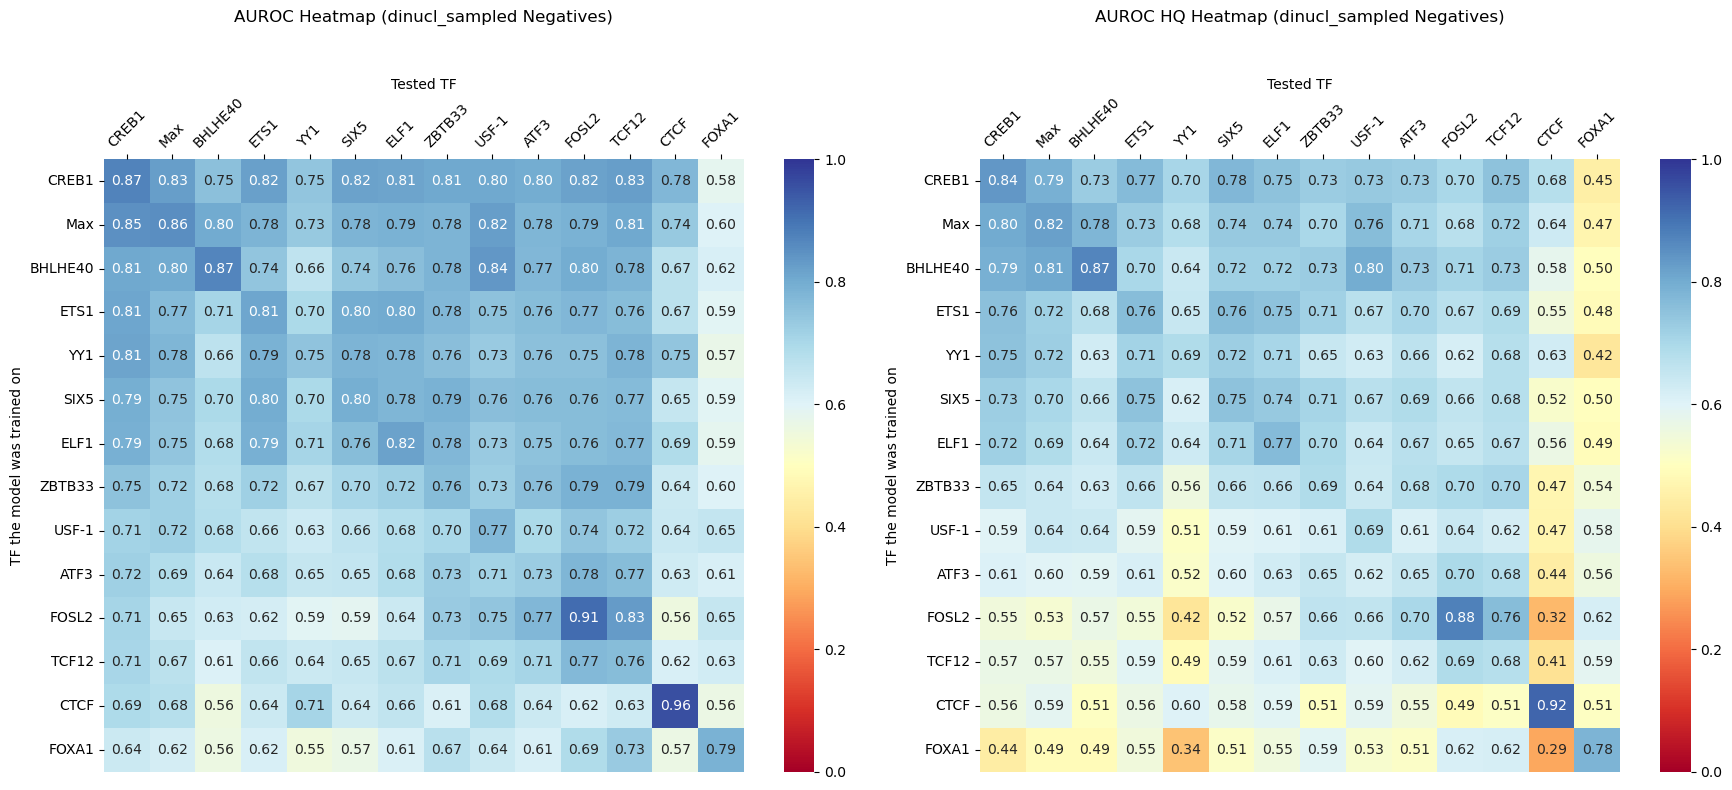

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

AUROC_df = cross_TF_dfs["A549_dinucl_sampled_CV-0_AUROC"]
TF_order = AUROC_df.mean(axis=1).sort_values(ascending=False).index.to_list()
AUROC_df = AUROC_df.loc[TF_order, TF_order]
AUROC_HQ_df = cross_TF_dfs["A549_dinucl_sampled_CV-0_AUROC_HQ"]
AUROC_HQ_df = AUROC_HQ_df.loc[TF_order, TF_order]
# Find global min and max for both heatmaps
# vmin = min(AUROC_HQ_df.min().min(), AUROC_df.min().min())
# vmax = max(AUROC_HQ_df.max().max(), AUROC_df.max().max())
vmin=0
vmax=1

# Plot side by side with the same color scale
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

short_labels_ordered = [label.split("_")[0] for label in TF_order]

# Normal AUROC heatmap
sns.heatmap(AUROC_df, annot=True, cmap="RdYlBu", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[0],
            vmin=vmin, vmax=vmax)
axes[0].xaxis.set_ticks_position('top')
axes[0].xaxis.set_label_position('top')
axes[0].set_title("AUROC Heatmap (dinucl_sampled Negatives)", pad=40)
axes[0].set_ylabel("TF the model was trained on")
axes[0].set_xlabel("Tested TF")
axes[0].tick_params(axis='x', rotation=45, labelrotation=45)

# HQ AUROC heatmap
sns.heatmap(AUROC_HQ_df, annot=True, cmap="RdYlBu", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[1],
            vmin=vmin, vmax=vmax)
axes[1].xaxis.set_ticks_position('top')
axes[1].xaxis.set_label_position('top')
axes[1].set_title("AUROC HQ Heatmap (dinucl_sampled Negatives)", pad=40)
axes[1].set_ylabel("TF the model was trained on")
axes[1].set_xlabel("Tested TF")
axes[1].tick_params(axis='x', rotation=45, labelrotation=45)

plt.tight_layout()
plt.show()

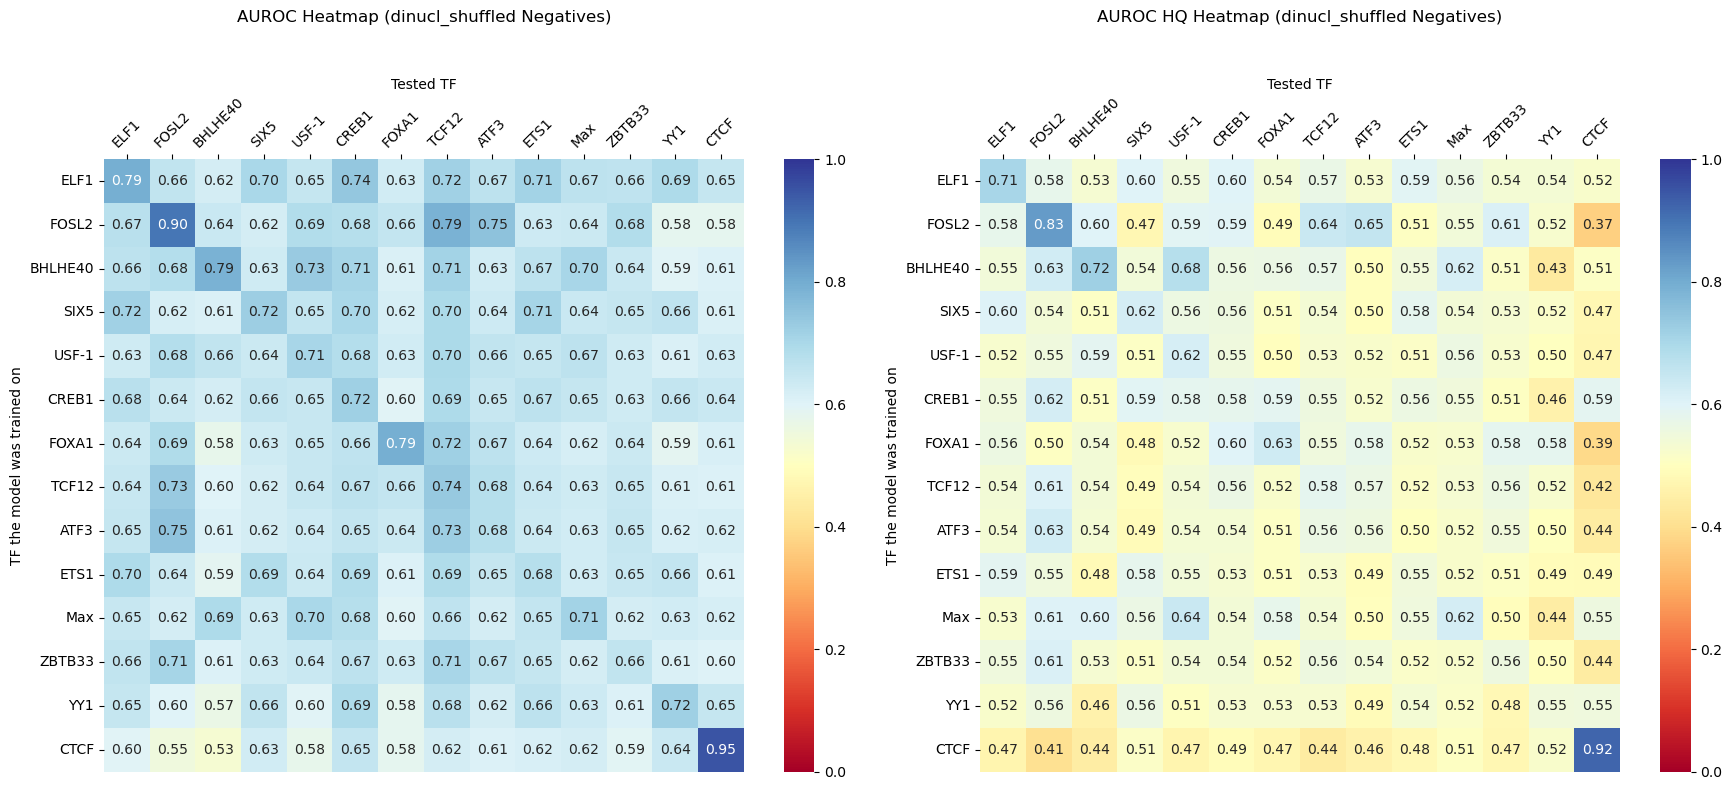

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

AUROC_df = cross_TF_dfs["A549_dinucl_shuffled_CV-0_AUROC"]
TF_order = AUROC_df.mean(axis=1).sort_values(ascending=False).index.to_list()
AUROC_df = AUROC_df.loc[TF_order, TF_order]
AUROC_HQ_df = cross_TF_dfs["A549_dinucl_shuffled_CV-0_AUROC_HQ"]
AUROC_HQ_df = AUROC_HQ_df.loc[TF_order, TF_order]
# Find global min and max for both heatmaps
# vmin = min(AUROC_HQ_df.min().min(), AUROC_df.min().min())
# vmax = max(AUROC_HQ_df.max().max(), AUROC_df.max().max())
vmin=0
vmax=1

# Plot side by side with the same color scale
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

short_labels_ordered = [label.split("_")[0] for label in TF_order]

# Normal AUROC heatmap
sns.heatmap(AUROC_df, annot=True, cmap="RdYlBu", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[0],
            vmin=vmin, vmax=vmax)
axes[0].xaxis.set_ticks_position('top')
axes[0].xaxis.set_label_position('top')
axes[0].set_title("AUROC Heatmap (dinucl_shuffled Negatives)", pad=40)
axes[0].set_ylabel("TF the model was trained on")
axes[0].set_xlabel("Tested TF")
axes[0].tick_params(axis='x', rotation=45, labelrotation=45)

# HQ AUROC heatmap
sns.heatmap(AUROC_HQ_df, annot=True, cmap="RdYlBu", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[1],
            vmin=vmin, vmax=vmax)
axes[1].xaxis.set_ticks_position('top')
axes[1].xaxis.set_label_position('top')
axes[1].set_title("AUROC HQ Heatmap (dinucl_shuffled Negatives)", pad=40)
axes[1].set_ylabel("TF the model was trained on")
axes[1].set_xlabel("Tested TF")
axes[1].tick_params(axis='x', rotation=45, labelrotation=45)

plt.tight_layout()
plt.show()

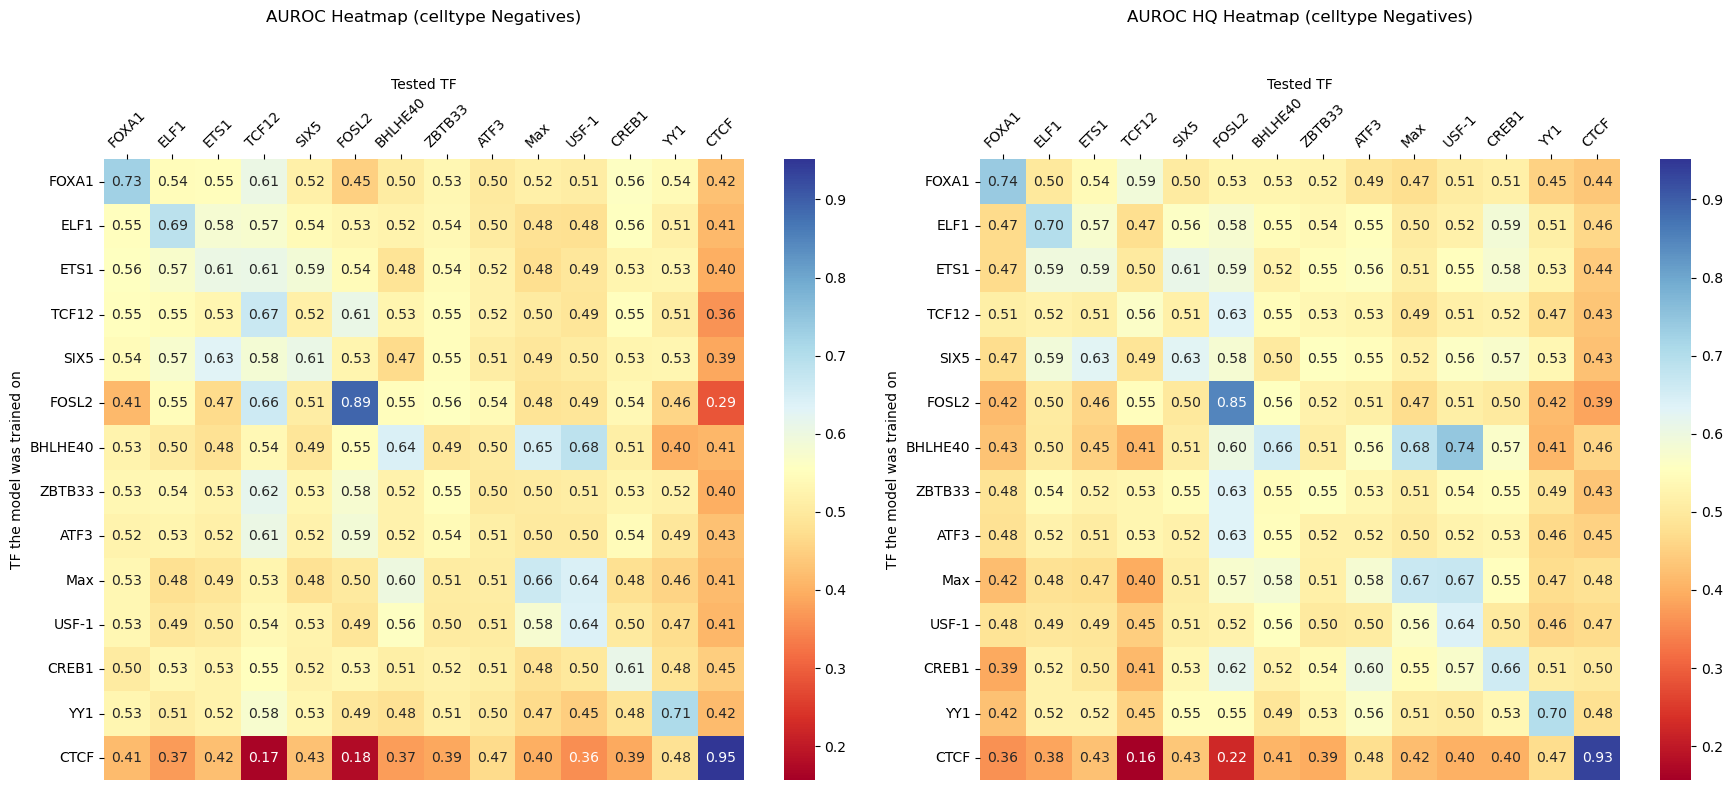

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

AUROC_df = cross_TF_dfs["A549_celltype_CV-0_AUROC"]
TF_order = AUROC_df.mean(axis=1).sort_values(ascending=False).index.to_list()
AUROC_df = AUROC_df.loc[TF_order, TF_order]
AUROC_HQ_df = cross_TF_dfs["A549_celltype_CV-0_AUROC_HQ"]
AUROC_HQ_df = AUROC_HQ_df.loc[TF_order, TF_order]
# Find global min and max for both heatmaps
vmin = min(AUROC_HQ_df.min().min(), AUROC_df.min().min())
vmax = max(AUROC_HQ_df.max().max(), AUROC_df.max().max())
# vmin=0
# vmax=1

# Plot side by side with the same color scale
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

short_labels_ordered = [label.split("_")[0] for label in TF_order]

# Normal AUROC heatmap
sns.heatmap(AUROC_df, annot=True, cmap="RdYlBu", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[0],
            vmin=vmin, vmax=vmax)
axes[0].xaxis.set_ticks_position('top')
axes[0].xaxis.set_label_position('top')
axes[0].set_title("AUROC Heatmap (celltype Negatives)", pad=40)
axes[0].set_ylabel("TF the model was trained on")
axes[0].set_xlabel("Tested TF")
axes[0].tick_params(axis='x', rotation=45, labelrotation=45)

# HQ AUROC heatmap
sns.heatmap(AUROC_HQ_df, annot=True, cmap="RdYlBu", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[1],
            vmin=vmin, vmax=vmax)
axes[1].xaxis.set_ticks_position('top')
axes[1].xaxis.set_label_position('top')
axes[1].set_title("AUROC HQ Heatmap (celltype Negatives)", pad=40)
axes[1].set_ylabel("TF the model was trained on")
axes[1].set_xlabel("Tested TF")
axes[1].tick_params(axis='x', rotation=45, labelrotation=45)

plt.tight_layout()
plt.show()

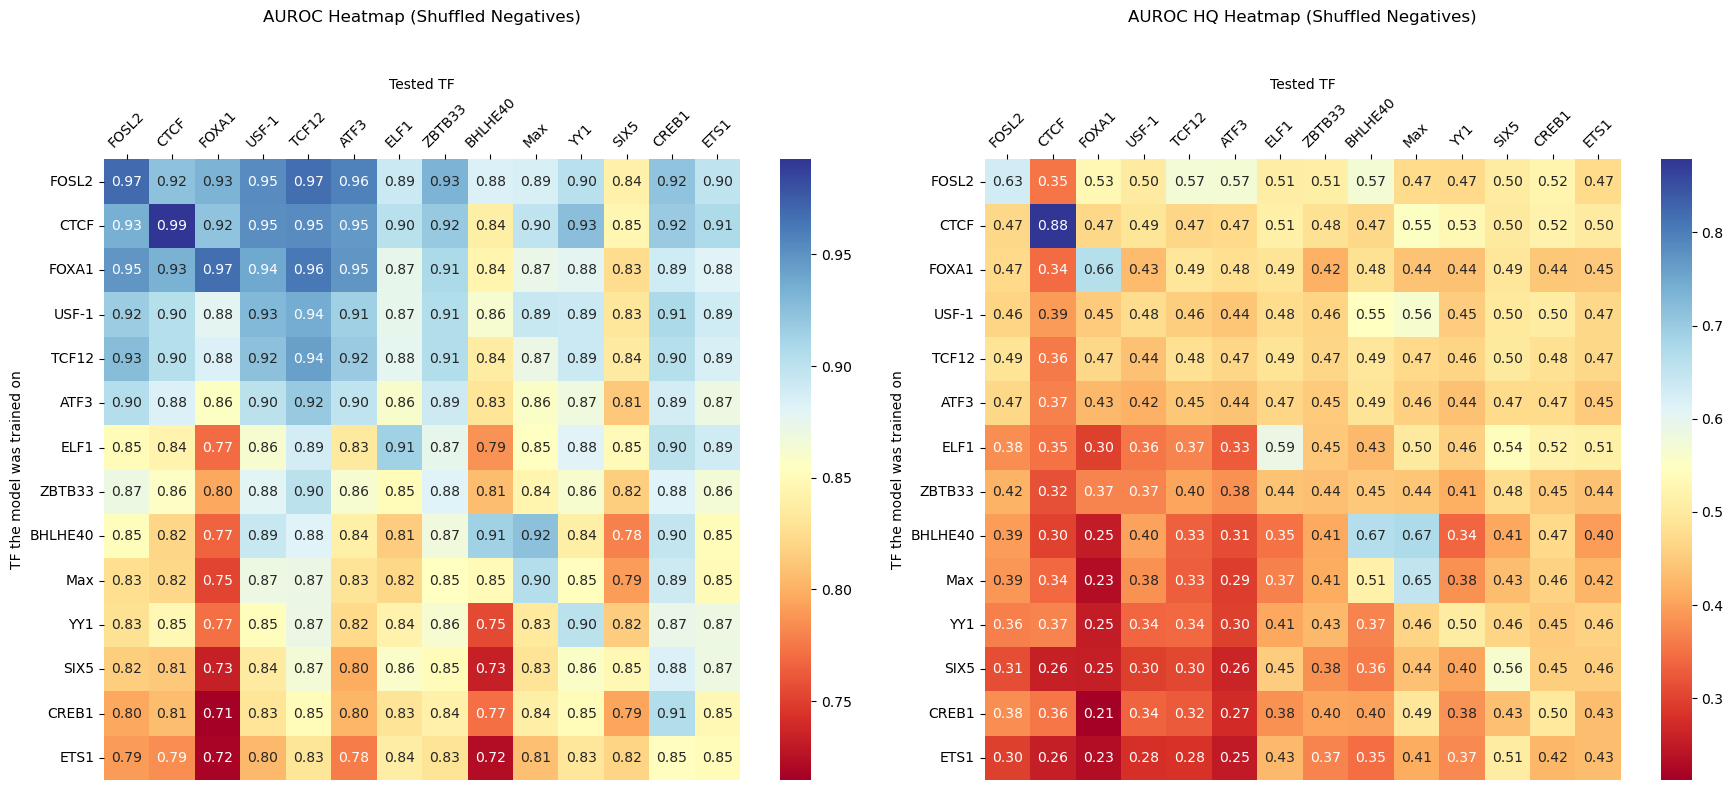

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

AUROC_df = cross_TF_dfs["A549_shuffled_CV-0_AUROC"]
TF_order = AUROC_df.mean(axis=1).sort_values(ascending=False).index.to_list()
AUROC_df = AUROC_df.loc[TF_order, TF_order]
AUROC_HQ_df = cross_TF_dfs["A549_shuffled_CV-0_AUROC_HQ"]
AUROC_HQ_df = AUROC_HQ_df.loc[TF_order, TF_order]

# Plot side by side with the same color scale
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

short_labels_ordered = [label.split("_")[0] for label in TF_order]

# Normal AUROC heatmap
sns.heatmap(AUROC_df, annot=True, cmap="RdYlBu", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[0])
axes[0].xaxis.set_ticks_position('top')
axes[0].xaxis.set_label_position('top')
axes[0].set_title("AUROC Heatmap (Shuffled Negatives)", pad=40)
axes[0].set_ylabel("TF the model was trained on")
axes[0].set_xlabel("Tested TF")
axes[0].tick_params(axis='x', rotation=45, labelrotation=45)

# HQ AUROC heatmap
sns.heatmap(AUROC_HQ_df, annot=True, cmap="RdYlBu", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[1])
axes[1].xaxis.set_ticks_position('top')
axes[1].xaxis.set_label_position('top')
axes[1].set_title("AUROC HQ Heatmap (Shuffled Negatives)", pad=40)
axes[1].set_ylabel("TF the model was trained on")
axes[1].set_xlabel("Tested TF")
axes[1].tick_params(axis='x', rotation=45, labelrotation=45)

plt.tight_layout()
plt.show()

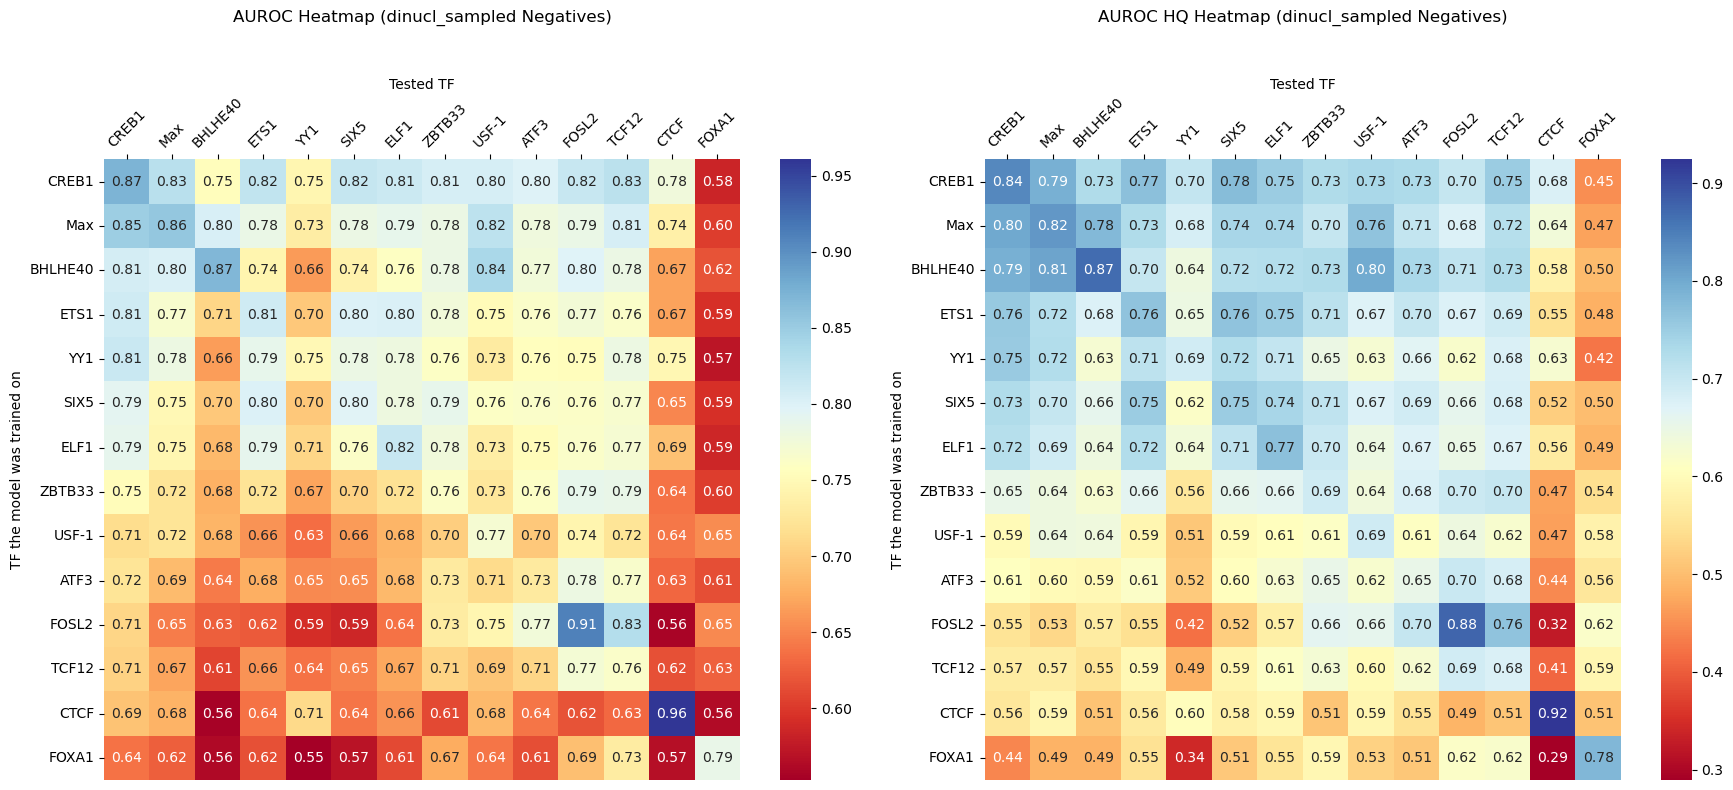

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

AUROC_df = cross_TF_dfs["A549_dinucl_sampled_CV-0_AUROC"]
TF_order = AUROC_df.mean(axis=1).sort_values(ascending=False).index.to_list()
AUROC_df = AUROC_df.loc[TF_order, TF_order]
AUROC_HQ_df = cross_TF_dfs["A549_dinucl_sampled_CV-0_AUROC_HQ"]
AUROC_HQ_df = AUROC_HQ_df.loc[TF_order, TF_order]


# Plot side by side with the same color scale
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

short_labels_ordered = [label.split("_")[0] for label in TF_order]

# Normal AUROC heatmap
sns.heatmap(AUROC_df, annot=True, cmap="RdYlBu", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[0])
axes[0].xaxis.set_ticks_position('top')
axes[0].xaxis.set_label_position('top')
axes[0].set_title("AUROC Heatmap (dinucl_sampled Negatives)", pad=40)
axes[0].set_ylabel("TF the model was trained on")
axes[0].set_xlabel("Tested TF")
axes[0].tick_params(axis='x', rotation=45, labelrotation=45)

# HQ AUROC heatmap
sns.heatmap(AUROC_HQ_df, annot=True, cmap="RdYlBu", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[1])
axes[1].xaxis.set_ticks_position('top')
axes[1].xaxis.set_label_position('top')
axes[1].set_title("AUROC HQ Heatmap (dinucl_sampled Negatives)", pad=40)
axes[1].set_ylabel("TF the model was trained on")
axes[1].set_xlabel("Tested TF")
axes[1].tick_params(axis='x', rotation=45, labelrotation=45)

plt.tight_layout()
plt.show()

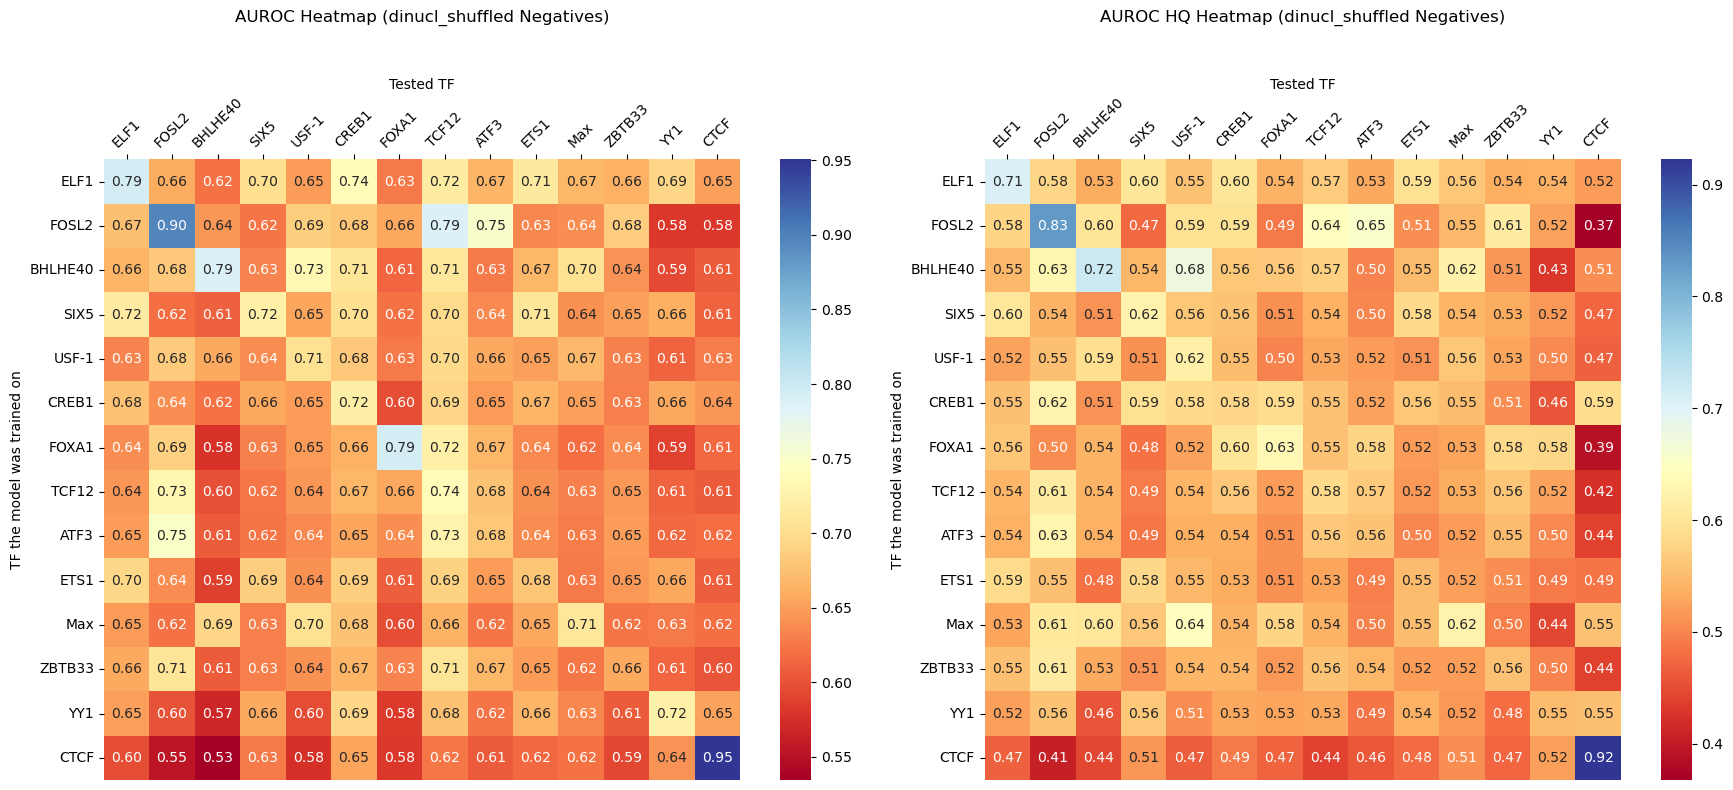

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

AUROC_df = cross_TF_dfs["A549_dinucl_shuffled_CV-0_AUROC"]
TF_order = AUROC_df.mean(axis=1).sort_values(ascending=False).index.to_list()
AUROC_df = AUROC_df.loc[TF_order, TF_order]
AUROC_HQ_df = cross_TF_dfs["A549_dinucl_shuffled_CV-0_AUROC_HQ"]
AUROC_HQ_df = AUROC_HQ_df.loc[TF_order, TF_order]

# Plot side by side with the same color scale
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

short_labels_ordered = [label.split("_")[0] for label in TF_order]

# Normal AUROC heatmap
sns.heatmap(AUROC_df, annot=True, cmap="RdYlBu", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[0])
axes[0].xaxis.set_ticks_position('top')
axes[0].xaxis.set_label_position('top')
axes[0].set_title("AUROC Heatmap (dinucl_shuffled Negatives)", pad=40)
axes[0].set_ylabel("TF the model was trained on")
axes[0].set_xlabel("Tested TF")
axes[0].tick_params(axis='x', rotation=45, labelrotation=45)

# HQ AUROC heatmap
sns.heatmap(AUROC_HQ_df, annot=True, cmap="RdYlBu", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[1])
axes[1].xaxis.set_ticks_position('top')
axes[1].xaxis.set_label_position('top')
axes[1].set_title("AUROC HQ Heatmap (dinucl_shuffled Negatives)", pad=40)
axes[1].set_ylabel("TF the model was trained on")
axes[1].set_xlabel("Tested TF")
axes[1].tick_params(axis='x', rotation=45, labelrotation=45)

plt.tight_layout()
plt.show()

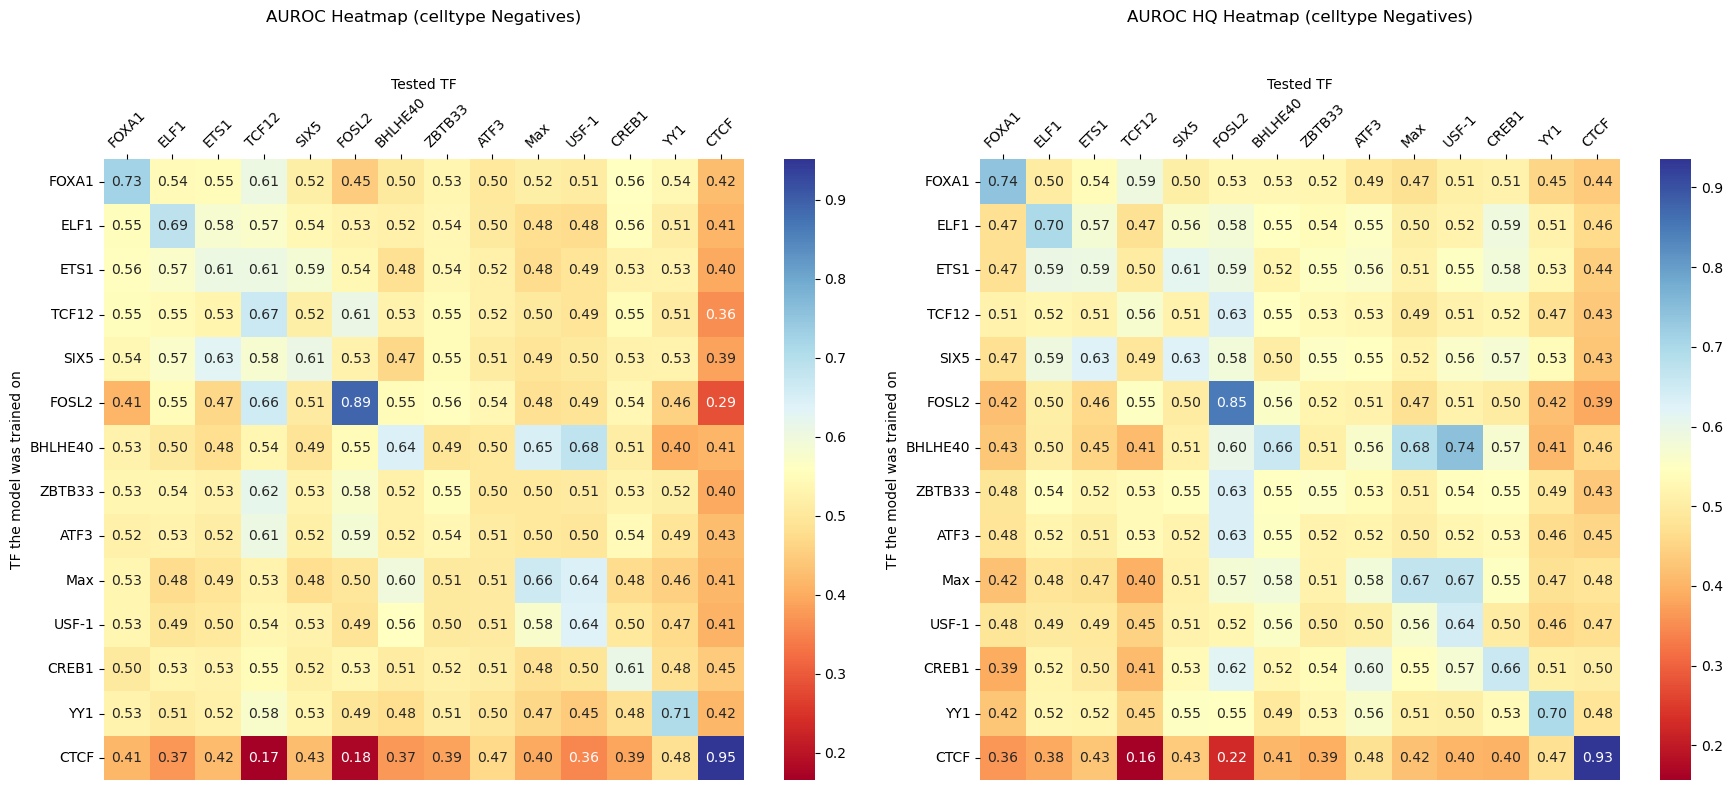

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

AUROC_df = cross_TF_dfs["A549_celltype_CV-0_AUROC"]
TF_order = AUROC_df.mean(axis=1).sort_values(ascending=False).index.to_list()
AUROC_df = AUROC_df.loc[TF_order, TF_order]
AUROC_HQ_df = cross_TF_dfs["A549_celltype_CV-0_AUROC_HQ"]
AUROC_HQ_df = AUROC_HQ_df.loc[TF_order, TF_order]


# Plot side by side with the same color scale
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

short_labels_ordered = [label.split("_")[0] for label in TF_order]

# Normal AUROC heatmap
sns.heatmap(AUROC_df, annot=True, cmap="RdYlBu", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[0])
axes[0].xaxis.set_ticks_position('top')
axes[0].xaxis.set_label_position('top')
axes[0].set_title("AUROC Heatmap (celltype Negatives)", pad=40)
axes[0].set_ylabel("TF the model was trained on")
axes[0].set_xlabel("Tested TF")
axes[0].tick_params(axis='x', rotation=45, labelrotation=45)

# HQ AUROC heatmap
sns.heatmap(AUROC_HQ_df, annot=True, cmap="RdYlBu", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[1])
axes[1].xaxis.set_ticks_position('top')
axes[1].xaxis.set_label_position('top')
axes[1].set_title("AUROC HQ Heatmap (celltype Negatives)", pad=40)
axes[1].set_ylabel("TF the model was trained on")
axes[1].set_xlabel("Tested TF")
axes[1].tick_params(axis='x', rotation=45, labelrotation=45)

plt.tight_layout()
plt.show()

In [10]:
import pickle

with open("/data/home/natant/Negatives/TFBS_negatives/testing_ground/20250613_NUMBER_OF_POSITIVES_PER_GROUP.pkl", "rb") as f:
    number_of_positives = pickle.load(f)
# Convert the nested dictionary 'number_of_positives' into a pandas DataFrame
number_of_positives_df = (
    pd.DataFrame([
        {"celltype": ct, "TF": tf, "positives 1": vals[0], "positives 2": vals[1], "positives 3": vals[2]}
        for ct, tf_dict in number_of_positives.items()
        for tf, vals in tf_dict.items()
    ])
)
number_of_positives_df



celltype                 TF  positives 1  positives 2  positives 3
0      MCF-7               CTCF         7124         5733         8144
1      MCF-7             TCF7L2         2909         2949         4439
2      MCF-7             ZNF217         2911         2775         4259
3      MCF-7     GATA3_(SC-268)         1853         1606         2624
4    GM12878               CTCF        12222        12053        15832
..       ...                ...          ...          ...          ...
127     A549              USF-1         2170         2457         3821
128     A549               ETS1         1535         1503         2503
129     A549               SIX5         1488         1318         2109
130     A549             ZBTB33         1896         2039         3222
131     A549  FOXA1_(SC-101058)         2180         2119         3401

[132 rows x 5 columns]

In [11]:
number_of_positives_df[number_of_positives_df["celltype"] == "A549"]

celltype                 TF  positives 1  positives 2  positives 3
118     A549               CTCF        13342        13624        18769
119     A549       YY1_(SC-281)         2807         2951         4519
120     A549     CREB1_(SC-240)         4496         4598         6813
121     A549                Max         2668         2801         4422
122     A549              TCF12         5817         5829         9260
123     A549              FOSL2         7796         8467        12500
124     A549      ELF1_(SC-631)         2357         2480         3781
125     A549            BHLHE40          850          890         1385
126     A549               ATF3         1631         1876         3081
127     A549              USF-1         2170         2457         3821
128     A549               ETS1         1535         1503         2503
129     A549               SIX5         1488         1318         2109
130     A549             ZBTB33         1896         2039         3222
131     A549  FOXA1_(SC-101058)         2180         2119         3401

In [22]:
short_labels_ordered

['FOSL2',
 'CTCF',
 'FOXA1',
 'USF-1',
 'TCF12',
 'ATF3',
 'ELF1',
 'ZBTB33',
 'BHLHE40',
 'Max',
 'YY1',
 'SIX5',
 'CREB1',
 'ETS1']

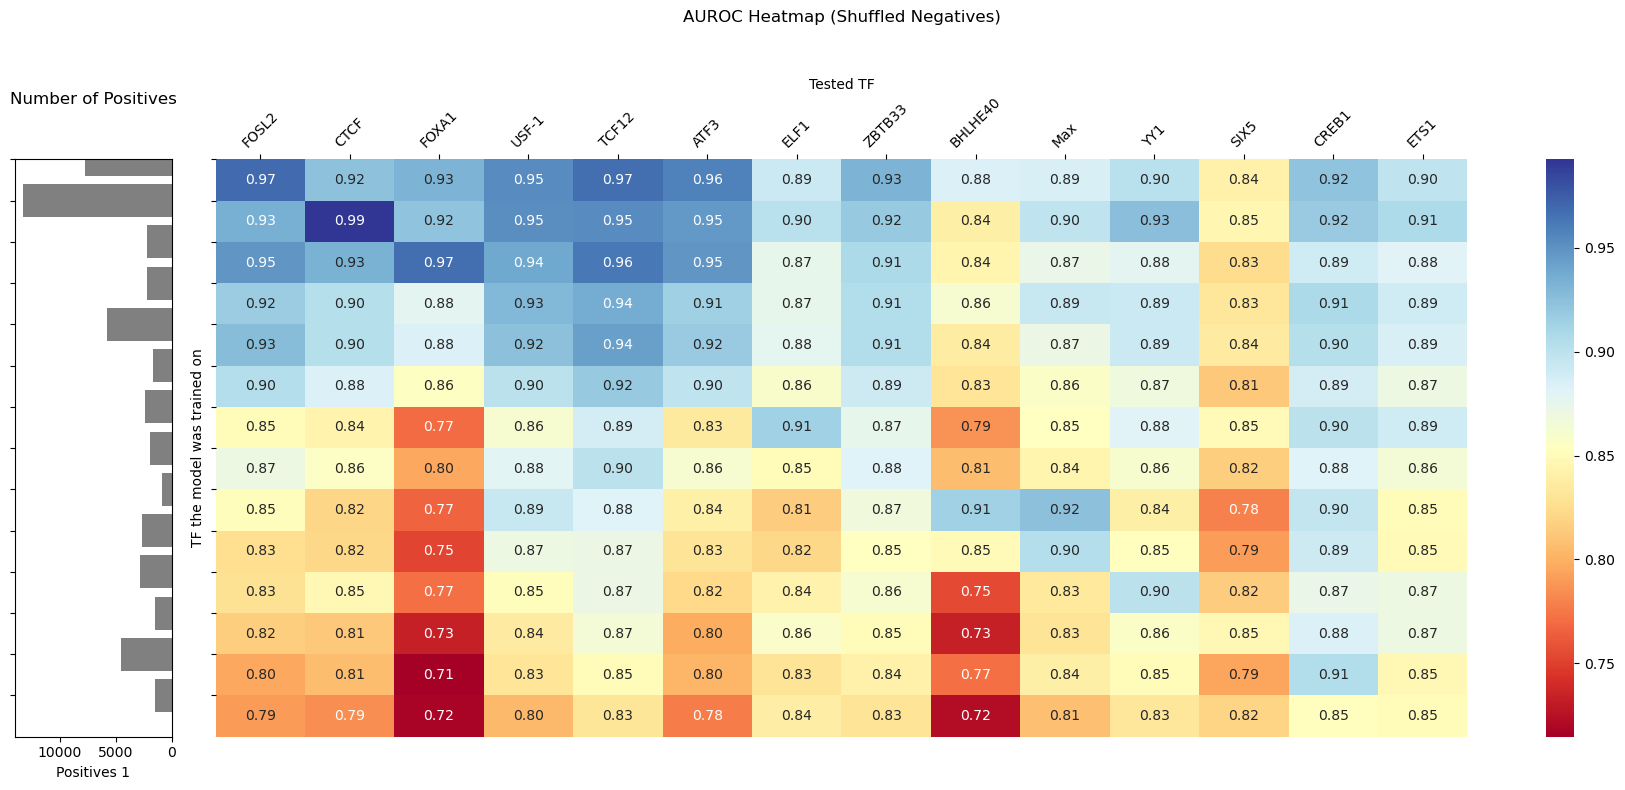

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

AUROC_df = cross_TF_dfs["A549_shuffled_CV-0_AUROC"]
TF_order = AUROC_df.mean(axis=1).sort_values(ascending=False).index.to_list()
AUROC_df = AUROC_df.loc[TF_order, TF_order]
AUROC_HQ_df = cross_TF_dfs["A549_shuffled_CV-0_AUROC_HQ"]
AUROC_HQ_df = AUROC_HQ_df.loc[TF_order, TF_order]
# Find global min and max for both heatmaps
vmin = AUROC_df.min().min()
vmax = AUROC_df.max().max()
# vmin=0
# vmax=1
# Plot side by side with the same color scale
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True, width_ratios=[0.1, 1])

short_labels_ordered = [label.split("_")[0] for label in TF_order]

# Normal AUROC heatmap
sns.heatmap(AUROC_df, annot=True, cmap="RdYlBu", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[1],
            vmin=vmin, vmax=vmax)
axes[1].xaxis.set_ticks_position('top')
axes[1].xaxis.set_label_position('top')
axes[1].set_title("AUROC Heatmap (Shuffled Negatives)", pad=40)
axes[1].set_ylabel("TF the model was trained on")
axes[1].set_xlabel("Tested TF")
axes[1].tick_params(axis='x', rotation=45, labelrotation=45)

a549_positives = number_of_positives_df[number_of_positives_df["celltype"] == "A549"]
positives_map = dict(zip(a549_positives["TF"], a549_positives["positives 1"]))
positives_in_order = [positives_map[tf] for tf in TF_order]

# Plot the barplot on axes[1]
axes[0].barh(range(len(TF_order)), positives_in_order, color='gray')
axes[0].set_yticks(range(len(TF_order)))
axes[0].set_yticklabels([])  # Hide yticklabels (already on heatmap)
axes[0].invert_xaxis()  # To match heatmap order
axes[0].set_xlabel("Positives 1")
axes[0].set_title("Number of Positives", pad=40)
plt.tight_layout()
plt.show()